# Optimising Parameterised Quantum Circuit (PQC) for the Wave Equation
In this notebook we give further explanation into the optimisation of the PQC used in [pqc_tutorial.ipynb](pqc_tutorial.ipynb).
Choosing a brickwall structure with general $SU4$ unitaries, we will see that large depths are required to represent the evolutionary operator, $U = e^{-i \Delta t H}$, due to the long-range interactions found in the Hamiltonian, $H$.
Note that for the same reason, Trotterisation performs poorly as the number of terms in the Pauli sum representing the Hamiltonian grow exponentially with the number of qubits.

## Import packages
We use `quimb` to optimise the PQC --- since it uses `jax` as a backend the updates for the PQC make use of "just-in-time" compilation, making them very fast once the computational graph has been compiled.

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [2]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

## Define PQC
In this section we construct the PQC with a brickwall structure and general $SU4$ unitaries.
Due to the non-local nature of the Hamiltonian, we choose a large circuit depth with respect to the number of qubits.
Therefore, unless significant advances in optimisation techniques can be made, this PQC approach to approximating the evolutionary operator does not scale well, and other alternate methods should be considered.

### Define parameters
Define parameters used to construct the PQC.
Since we are using `jax` for the parameter updates, we can afford to have a relatively high number of step updates without taking up a lot of additional computational time.

In [3]:
num_qubits = 5  # Number of qubits.
N = 2**num_qubits  # Number of grid points.

depth = 30  # Depth of PQC.
t = 0.01  # Time length of evolution.
steps = 20000  # Maximum number of optimisation steps.

### Construct PQC Ansatz
Construct PQC using brickwall structure.
Since `quimb` has parameterised $SU4$ gates, there is no need to decompose them into fundamental gates.
We can also use `quimb` to visualise our circuit in a graph, or more specifically a tensor network, form.

In [4]:
def brickwall(n, circ_depth):
    """Construct parameterised brickwall circuit. The values of the parameters are randomly initialised
       according to a uniform distribution.

    Args:
        n: int: Number of qubits for circuit.
        circ_depth: int: Number of layers within the circuit.

    """

    # Define circuit.
    circ = qtn.Circuit(n)

    # Iterative over layers. One layer consists of all qubits acted upon by at least one gate.
    for r in range(circ_depth):

        for i in range(0, circ.N // 2):
            circ.apply_gate(
                "SU4",
                *qu.randn(15, dist="uniform"),
                2 * i,
                2 * i + 1,
                parametrize=True,
                gate_round=r,
            )

        for i in range(0, circ.N // 2):
            if 2 * (i + 1) < circ.N:
                circ.apply_gate(
                    "SU4",
                    *qu.randn(15, dist="uniform"),
                    2 * i + 1,
                    2 * (i + 1),
                    parametrize=True,
                    gate_round=r,
                )
    return circ

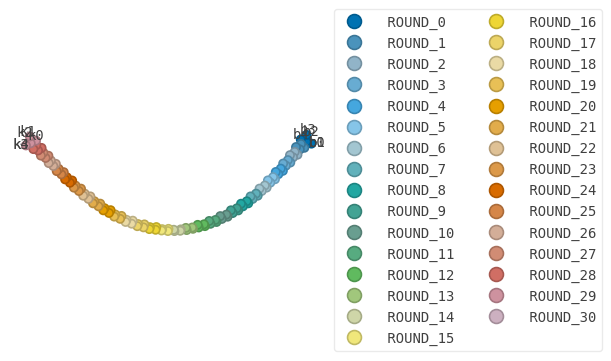

In [5]:
pqc_circuit = brickwall(num_qubits, depth)  # Construct PQC
pqc_unitary = pqc_circuit.get_uni(
    transposed=False
)  # Obtain tensor network representation of PQC
pqc_unitary.draw(
    color=[f"ROUND_{i}" for i in range(depth + 1)], show_inds=True
)  # Draw tensor network

## Optimise PQC
In this section we train our PQC in order to approximate the evolutionary operator, $U$.
The cost function used to optimise the parameters of the circuit is given by,
\begin{equation}
C(\theta) = \text{Re}\text{Tr}\left( U(\theta) e^{-iH\Delta t}  \right) \nonumber,
\end{equation}
where $U(\theta)$ is the PQC and $e^{-iH\Delta t}$ is the exact evolutionary operator for time $\Delta t$.
Since we are using a relatively low number of qubits, we can compute the exact evolutionary operator at any time, $t$, in the cost function.
For a higher number of qubits, the cost function can be computed by using very small time slices in order to get efficent representations of $U$.
Once the PQC has been optimised for those small times, the resultant PQC and small time sliced evolutionary operator are then used to compute the cost function for larger times --- more details for this procedure can be found [here](https://arxiv.org/pdf/2205.11427.pdf).

Consequentially, the error between the optimised PQC and $U$ is given by,
\begin{equation}
\epsilon = \sqrt{1 - \text{Re}\text{Tr}(U(\theta^{\text{opt}})^{\dagger} e^{-iH\Delta t})}/2^n.\nonumber
\end{equation}


### Construct Hamiltonian
The Hamiltonian is constructed using the graph analogy discussed in the theory of [pqc_tutorial.ipynb](../pqc_tutorial.ipynb).
The off-diagonal blocks of $H$ correspond to the incidence matrix of the discretised graph Laplacian, $L$. 
Therefore, in order to compute $H$ we must first compute the incidence matrix, $B$.
More details about this construction with the relevant boundary conditions can be found [here](https://arxiv.org/pdf/1711.05394.pdf).

In [6]:
def next_power_of_two(n: int):
    """Returns upper ceiling on next power of two for n."""
    return 1 << (n - 1).bit_length()


def construct_B(N):
    """Compute the incidence matrix of L using Neumann boundary conditions."""
    B = np.zeros((N // 2, N // 2 + 1))
    for i in range(N // 2):
        B[i, i] = -1
        B[i, i + 1] = 1
    return B[:, 1:-1]


def construct_H(N):
    """Compute Hamiltonian, H from B.
    In accordance to the wave equation,
    H = (1/a) * [[0,B],[B^{dagger},0]]

    Args:
      N: int: Number of grid points.
      a: Float: Spacing between discretised points.
    """
    # Ensure vertices space is equivalent to qubit space (has same dimension)
    if np.ceil(np.log2(N)) != np.floor(np.log2(N)):
        raise ValueError(f"N = {N} must be a power of two.")

    B = construct_B(N)
    v, e = B.shape
    n = next_power_of_two(v + e)

    H = np.zeros((n, n))
    H[:v, v : v + e] = B
    H[v : v + e, :v] = B.T
    a = 1 / N
    return (1 / a) * H


H = construct_H(N)

### Construct target unitary
Construct target unitary used in the cost function from the Hamiltonian.
Expressing $U$ as a `quimb.tensor.Tensor` with appropriatly labelled indices ensures that the target unitary is constracted with the PQC correctly. 

In [7]:
def get_U_target(H, t):
    """Constuct evolutionary unitary, $U=e^{-iHt}$

    Args:
       H: array: Hamiltonian.
       t: float: time slice.
    """
    n = int(np.log2(len(H)))
    U_target = qtn.Tensor(
        data=(qu.expm(-1j * H * t)).reshape([2] * (2 * n)),
        inds=[f"k{i}" for i in range(n)] + [f"b{i}" for i in range(n)],
        tags={"U_TARGET"},
    )
    return U_target

### Construct cost function
Construct cost function, also known as the Frobenius product, from the PQC and target unitary.
The `optimize` `kwarg` defines the contraction path taken by the cost function. 

As we can see, the initial PQC and target unitary have a low overlap with eachother, which is to be expected.

In [8]:
def fp(U_circ, U_target):
    return -np.real((U_circ.H & U_target).contract(all, optimize="auto-hq"))

In [9]:
U_target = get_U_target(H, t)
fp(pqc_unitary, U_target)

-0.29341786351215426

### Optimise PQC
Optimise parameters of circuit with gradient descent using psuedo-global newton method, L-BFGS. 

We can see that the optimised PQC has an extremely high overlap with the target unitary.

In [10]:
def optimise_circuit(U_circ, U_target, steps):

    # Initialise optimiser
    tnopt = qtn.TNOptimizer(
        U_circ,  # the tensor network we want to optimize
        fp,  # the function we want to minimize
        loss_constants={"U_target": U_target},
        tags=["SU4"],  # Gates to optimise change with ansatz.
        autodiff_backend="jax",
        optimizer="L-BFGS-B",  # the optimization algorithm
        progbar=True,
    )

    # Optimise circuit
    V_opt = tnopt.optimize(
        n=steps,
        tol=1e-16,  # Optimise to machine precision.
        ftol=1e-16,
        gtol=1e-16,
        maxfun=steps,  # Maximum number of times to evaluate cost function.
    )
    return V_opt

In [11]:
# Optimise circuit --- ansatz circuit is initialise as previously optimised PQC.
opt_pqc_unitary = optimise_circuit(pqc_unitary, U_target, steps)

  0%|          | 0/20000 [00:00<?, ?it/s]

-31.999999999760 [best: -31.999999999760] :  60%|██████    | 12094/20000 [15:03<09:50, 13.39it/s] 


In [12]:
# Update circuit with optimised angles
pqc_circuit.update_params_from(opt_pqc_unitary)

## Save/load Optimised PQC
Save circuit object using quimb save function.


In [13]:
qu.save_to_disk(pqc_circuit, "../data/optimised_PQC")
pqc_unitary = qu.load_from_disk("../data/optimised_PQC").get_uni(transposed=False)
fp(pqc_unitary, U_target)

-31.999999999760465